### Antes de começar

Note que métodos de redução de dimensionalidade são importantes quando temos muitos descritores e poucas amostras. Quando esse não é o caso, modelos de aprendizado de máquina mais avançados, como *Random Forest*, podem extrair mais informação quando usamos mais descritores, e em geral são capazes de evitar problemas associados ao uso de muitos descritores, como sobreajuste (*overfitting*). Dessa forma, os exemplos apresentados a seguir têm o objetivo de demonstrar alguns métodos de seleção de variáveis, e não são necessariamente a melhor escolha para o conjunto de dados utilizado (por isso, é observado um desempenho pior nos modelos em que realizamos a seleção de variáveis).

Em resumo, a resposta para "Devo usar um método de redução de dimensionalidade?" é: experimente. Se seu modelo ficar bom (simples, interpretável, sem sobreajuste) usando muitas variáveis, use-o. Se não, explore os métodos apresentados a seguir e veja se obtém um desempenho melhor.

# Dimensionalidade

Esse termo se refere ao número de dimensões, ou seja, de descritores do nosso sistema. Por exemplo, se nossos dados são descritos por apenas duas variáveis, podemos mostrar os dados em um gráfico bidimensional com dois eixos, assim, dizemos que nossos dados estão em um espaço de duas dimensões.

Em geral, quanto mais descritores temos para nossos dados, mais detalhada fica nossa descrição do sistema. Em outras palavras, é maior a chance de que pequenas variações nos dados possam ser explicadas por uma combinação de diferentes descritores. Entretanto, se temos muitos descritores para poucos dados, corremos o risco de "modelar o erro", ou seja, as pequenas variações deixam de ter significado por se tratarem apenas de ruído. Isso pode levar à criação de modelos **sobreajustados** (*overfitted*) aos dados de treinamento, que não terão um bom desempenho para prever dados futuros.

Além disso, existe um fenômeno denominado "maldição da dimensionalidade". Em resumo, dados em muitas dimensões ficam "esparsos", espalhados por esse espaço multidimensional, o que é um problema para modelos que dependem do cálculo de distâncias entre os pontos, que ficam todas aproximadamente as mesmas em muitas dimensões. Além disso, é impossível fazer uma amostragem representativa de todo o espaço, pois o número de dados necessários cresce exponencialmente com o número de dimensões.

Dessa forma, quando temos poucos dados e muitos descritores, remover variáveis pouco relevantes (ou redundantes) pode ser uma ferramenta interessante para melhorar o desempenho dos nossos modelos. Vejamos algumas formas de reduzir a dimensionalidade no conjunto de dados de Delaney, que contém 1128 compostos e seus valores de solubilidade.

In [31]:
import numpy as np
import pandas as pd

df = pd.read_csv("delaney-processed.csv")
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [32]:
# Contagem de compostos na tabela
len(df)

1128

Vamos desprezar os descritores que vêm no arquivo .csv e usar o RDKit para calcular 100 descritores físico-químicos para nosso conjunto de dados.

In [33]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

names = [name[0] for name in Descriptors.descList][:100]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(names)
descs = [calc.CalcDescriptors(Chem.MolFromSmiles(cpd)) for cpd in df["smiles"]]

descriptors_df = pd.DataFrame(descs, columns=names)
descriptors_df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0.000000,10.315180,-16.476443,-1.139614,0.0,0.650000,32,7,12,0
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0.482297,10.988763,1.509167,1.763796,0.0,0.083333,15,1,3,0
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0.000000,0.000000,6.681799,6.143627,0.0,0.500000,11,0,1,0
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0.000000,30.735126,0.000000,0.000000,0.0,0.000000,22,0,0,0
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0.000000,4.037037,0.000000,0.000000,0.0,0.000000,5,0,0,0


In [34]:
# Quantidade de amostras e descritores
descriptors_df.shape

(1128, 100)

Temos 1128 compostos, cada um representado por 100 descritores. Vamos separar um conjunto de treinamento e um de teste antes de prosseguir com a geração de modelos.

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(descriptors_df, 
                                                    df['measured log solubility in mols per litre'], 
                                                    test_size=0.25, 
                                                    random_state=100)

Ao preparar esse Notebook, notei dois pontos importantes, que destaco a seguir. Antes de fazer a seleção de variáveis:
1. Remova os descritores com variância nula (em que todos os valores na coluna são iguais)
2. Remova os descritores correlacionados (veja o Notebook ["Removendo descritores colineares"](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Removendo%20descritores%20colineares.ipynb))

Essas precauções são importantes para evitar erros e a seleção de variáveis que contêm a mesma informação.

In [36]:
# Removendo descritores com variância nula
# Devido ao floating-point error, o valor calculado para variância pode não ser exatamente zero
# Por isso, usamos o método isclose()
X_train = X_train.loc[:, ~np.isclose(0, X_train.var())]
X_test = X_test[X_train.columns]

# Removendo descritores correlacionados (R de Pearson > 0.9)
# Fonte: https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/

# Selecionar triângulo superior da matriz de correlação
corr_matrix = X_train.corr(method='pearson').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Índices das colunas com correlação maior que 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Remover colunas dos conjuntos de treino e teste
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

In [37]:
print(X_train.shape)
print(X_test.shape)

(846, 71)
(282, 71)


Restam 71 descritores. 

Primeiramente, vamos treinar um modelo de regressão linear com todos os descritores disponíveis e avaliar sua qualidade utilizando o conjunto de teste.

In [38]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print("Erro absoluto médio (treinamento): ", mae_train)
print("Erro absoluto médio (teste): ", mae_test)

Erro absoluto médio (treinamento):  0.52
Erro absoluto médio (teste):  0.563


Agora, vamos aplicar diferentes métodos de redução de número de descritores e comparar os resultados.

## 1. Métodos não-supervisionados

O termo "não-supervisionado" indica que o método de seleção de variáveis não leva em conta o valor da variável dependente do nosso modelo, mas somente os valores dos descritores. 

### 1.1. PCA

PCA (análise de componentes principais) é um método não-supervisionado de redução de dimensionalidade, muito utilizado em áreas como quimiometria. Especificamente, a PCA considera quanto da *variância* dos dados é explicada por diferentes combinações de descritores. Pode ser visto como a realização de uma projeção dos dados em menos dimensões, de uma forma que os dados fiquem tão espalhados quanto for possível. A maior parte da variância está contida na primeira PC (componente principal), depois na segunda, e assim sucessivamente.

É recomendável padronizar ou normalizar os dados antes de fazer uma PCA. Note que a padronização do conjunto de treinamento é feita à parte do conjunto de teste, para que não ocorra o fenômeno denominado *data leakage*, quando informação do conjunto de teste "vaza" para o conjunto de treinamento, o que melhora as métricas de qualidade do modelo sem que seu desempenho seja, de fato, melhor. Para manter o padrão, vamos usar os dados padronizados para criar todos os modelos, mas note que nem sempre isso é necessário (por exemplo, modelos baseados em árvores não requerem padronização).

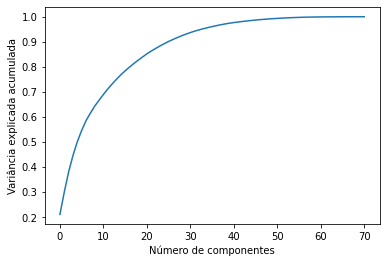

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# É recomendável normalizar os dados antes de fazer uma PCA
# Para manter o padrão, vamos usar os dados normalizados para criar todos os modelos
# Note que a normalização do conjunto de treinamento é feita à parte do conjunto de teste
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train) 
X_test_ss = ss.transform(X_test)

# Transformar dados para formato dataframe
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_test.columns)

# Cálculo das componentes principais
pca = PCA()
pca.fit_transform(X_train_ss)

# Variância explicada acumulada
# Fonte: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.show()

Veja que a partir de aproximadamente 50 componentes principais, já temos quase 100% da variância dos dados explicada. Vejamos como ficam modelos treinados com diferentes números de componentes principais. Reportamos o erro absoluto médio (MAE) para os conjuntos de treinamento e de teste.

In [40]:
results = []

# Selecionar valores progressivamente maiores de PCs para treinar os modelos
for i in [10, 30, 50, 70]:
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train_ss)
    X_test_pca = pca.transform(X_test_ss)

    reg = linear_model.LinearRegression()
    reg.fit(X_train_pca, y_train)

    y_pred_train = reg.predict(X_train_pca)
    y_pred_test = reg.predict(X_test_pca)

    mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
    mae_test = mean_absolute_error(y_test, y_pred_test).round(3)
    
    results.append([i, mae_train, mae_test])

pd.DataFrame(results, columns=["n° PCs", "MAE Treinamento", "MAE Teste"])

,n° PCs,MAE Treinamento,MAE Teste
0,10,0.717,0.728
1,30,0.609,0.611
2,50,0.563,0.601
3,70,0.520,0.563


Apesar de ser um bom método de redução de dimensionalidade, o método PCA não fornece descritores facilmente interpretáveis. Dessa forma, vamos agora explorar alguns métodos que selecionam os descritores mais relevantes, sem transformá-los.

## 2. Métodos supervisionados

Métodos supervisionados de seleção de variáveis levam em conta o valor da resposta, buscando selecionar as variáveis mais importantes para sua predição. 

Os métodos supervisionados podem ser separados em três tipos:
- *Wrapper* (não encontrei uma tradução): métodos que criam diversos modelos com diferentes subconjuntos de descritores, e selecionam a combinação com melhor desempenho. Exemplo: *Recursive Feature Elimination* (RFE)
- Filtro: avaliam a relevância de cada variável para descrever a resposta (por exemplo, calculando a correlação), e remove as menos descritivas. Um exemplo é o método de Seleção Univariada.
- Intrínsico: alguns modelos realizam seleção de variáveis como parte do processo de treinamento. Podemos citar os modelos *Lasso*, *Ridge Regression*, árvores de decisão e *Random Forest*.

### 2.1. Seleção de variáveis correlacionadas com a resposta

Vamos começar com um método de seleção simples, calculando o coeficiente de correlação entre cada variável e a resposta, e selecionando as variáveis com as melhores correlações (R² mais próximo de 1).

In [41]:
from scipy import stats

corr_df = pd.DataFrame(X_train.columns.T, columns=["Descritores"])
corr_coef = []

for col in X_train.columns:
    corr_coef.append(abs(stats.linregress(X_train[col], y_train)[2]))
    
corr_df["R-quadrado"] = corr_coef
corr_df = corr_df.sort_values("R-quadrado", ascending=False)
corr_df.head(20)  # 20 variáveis com as maiores correlações lineares com a resposta

,Descritores,R-quadrado
26,PEOE_VSA6,0.706840
4,MolWt,0.624322
7,FpDensityMorgan1,0.583932
11,BertzCT,0.578174
37,SMR_VSA7,0.525946
31,SMR_VSA10,0.520772
14,Kappa2,0.452298
27,PEOE_VSA7,0.438602
8,FpDensityMorgan2,0.432972
46,SlogP_VSA7,0.428244


In [42]:
var_sel = list(corr_df.head(20)["Descritores"])

In [43]:
# Treinar um modelo linear com as 20 variáveis selecionadas
reg = linear_model.LinearRegression()
reg.fit(X_train_ss[var_sel], y_train)

y_pred_train = reg.predict(X_train_ss[var_sel])
y_pred_test = reg.predict(X_test_ss[var_sel])

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print(f"Erro absoluto médio (treinamento): ", mae_train)
print(f"Erro absoluto médio (teste):       ", mae_test)

Erro absoluto médio (treinamento):  0.663
Erro absoluto médio (teste):        0.695


**Notas:**

Os dados não-padronizados foram usados para fazer essa análise pois o coeficiente de correlação não depende da escala, assim como os valores de y preditos pelo modelo.

Esse método é equivalente ao uso de SelectKBest (Seção 2.3.) usando o parâmetro `score_func=f_regression`.

### 2.2. Eliminação Recursiva de Atributos (RFE)

Este algoritmo é usado para selecionar os atributos mais relevantes para a predição da variável de resposta. O termo "wrapper" significa que o RFE utiliza um algoritmo (por exemplo, regressão linear ou árvores de decisão) para fazer a seleção das variáveis. 

Funcionamento: Um modelo utilizando todas as variáveis é ajustado aos dados. Em seguida, a variável menos importante (ou as variáveis, de acordo com o que for estabelecido pelo usuário) é descartada, e um novo modelo é ajustado com as variáveis restantes. Isso é repetido até que o número de variáveis do modelo atinja um certo valor (também estabelecido pelo usuário). A seleção é feita de acordo com o algoritmo utilizado, por algum critério estatístico.

In [44]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor

# Como nosso problema é de regressão, vamos usar o algoritmo de regressão com árvores de decisão
# Também vamos estabelecer que o modelo final deverá ter 20 variáveis (n_features_to_select) 
# e que as variáveis devem ser removidas de 1 em 1 (step)
rfe = RFE(estimator=DecisionTreeRegressor(), 
          n_features_to_select=20,
          step=1)

# Ajustar o modelo com os valores normalizados
rfe.fit(X_train_ss, y_train)
rfe.ranking_

array([ 1, 12,  1,  1,  1,  1,  1,  1, 11,  1,  1,  1,  5, 30,  1, 19, 42,
       31, 36, 47, 48, 40, 33, 50, 46, 44,  1,  1,  3, 23, 13, 14, 51, 38,
       35,  1, 25, 10, 49, 34,  1, 37, 32,  1, 24, 26, 39, 45,  1,  2, 22,
       52, 17, 16,  8,  7, 15,  6,  1,  1, 27,  9, 29, 20, 18,  1,  4, 43,
       21, 28, 41])

As 20 variáveis selecionadas pelo modelo são as que possuem o número 1 como índice. Vamos verificar quais são e compará-las com as selecionadas pelo método anterior.

In [45]:
# Comparar variáveis selecionadas
compare = pd.DataFrame()
compare["1.Correlação"] = corr_df.head(20)["Descritores"].tolist()
compare["2.RFE"] = X_train_ss.loc[:, rfe.ranking_ == 1].columns.tolist()
compare

,1.Correlação,2.RFE
0,PEOE_VSA6,MaxEStateIndex
1,MolWt,MinAbsEStateIndex
2,FpDensityMorgan1,qed
3,BertzCT,MolWt
4,SMR_VSA7,MaxPartialCharge
5,SMR_VSA10,MinPartialCharge
6,Kappa2,FpDensityMorgan1
7,PEOE_VSA7,FpDensityMorgan3
8,FpDensityMorgan2,BalabanJ
9,SlogP_VSA7,BertzCT


Note a semelhança entre as variáveis escolhidas - os dois métodos parecem concordar, de forma geral.

Vamos ver como fica o modelo de regressão treinado com as variáveis selecionadas.

In [46]:
# Transformar os dados (removendo as variáveis menos importantes) e treinar um modelo de regressão linear
X_train_rfe = rfe.transform(X_train_ss)
X_test_rfe = rfe.transform(X_test_ss)

reg = linear_model.LinearRegression()
reg.fit(X_train_rfe, y_train)

y_pred_train = reg.predict(X_train_rfe)
y_pred_test = reg.predict(X_test_rfe)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print(f"Erro absoluto médio (treinamento) com 20 variáveis: ", mae_train)
print(f"Erro absoluto médio (teste) com 20 variáveis:       ", mae_test)

Erro absoluto médio (treinamento) com 20 variáveis:  0.63
Erro absoluto médio (teste) com 20 variáveis:        0.648


### 2.3. Seleção Univariada (SelectKBest)

Note que diferentes funções são necessárias para realizar a seleção univariada, de acordo com a natureza dos dados de entrada e saída. Como temos dados numéricos de entrada e saída, podemos usar o teste-F para realizar a seleção de variáveis. Esse teste dá mais peso para variáveis que correlacionam de forma linear com a saída:

In [47]:
# from sklearn.feature_selection import f_classif  # ANOVA - numerical input, categorical output
# cat, cat = mutual_info_classif, chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression  # F-test statistics - numerical input, numerical output

# Seleção de variáveis
kbest = SelectKBest(score_func=f_regression, k=20).fit(X_train_ss, y_train)

X_train_kbest = kbest.transform(X_train_ss)
X_test_kbest = kbest.transform(X_test_ss)

In [48]:
# Adicionar ao dataframe de comparação
mask = kbest.get_support()
compare["3.SelectKBest"] = X_train_ss.columns[mask]
compare

,1.Correlação,2.RFE,3.SelectKBest
0,PEOE_VSA6,MaxEStateIndex,MolWt
1,MolWt,MinAbsEStateIndex,MinPartialCharge
2,FpDensityMorgan1,qed,FpDensityMorgan1
3,BertzCT,MolWt,FpDensityMorgan2
4,SMR_VSA7,MaxPartialCharge,BalabanJ
5,SMR_VSA10,MinPartialCharge,BertzCT
6,Kappa2,FpDensityMorgan1,Kappa2
7,PEOE_VSA7,FpDensityMorgan3,PEOE_VSA6
8,FpDensityMorgan2,BalabanJ,PEOE_VSA7
9,SlogP_VSA7,BertzCT,PEOE_VSA9


In [49]:
reg = linear_model.LinearRegression()
reg.fit(X_train_kbest, y_train)
print("Coeficientes:", reg.coef_)

Coeficientes: [ 0.17172866 -0.47868294  0.2664473  -0.13741577  0.0530506  -0.09673286
 -0.2966301  -0.66514289 -0.51252798 -0.04883094 -0.98049159 -0.19464546
 -0.28293591  0.62711984 -0.14865042  0.20226707 -0.15625145 -0.26964161
 -0.18296287 -0.17549339]


In [50]:
y_pred_train = reg.predict(X_train_kbest)
y_pred_test = reg.predict(X_test_kbest)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print("Erro absoluto médio (treinamento) com 20 variáveis:", mae_train)
print("Erro absoluto médio (teste) com 20 variáveis:      ", mae_test)

Erro absoluto médio (treinamento) com 20 variáveis: 0.663
Erro absoluto médio (teste) com 20 variáveis:       0.695


### 2.4. Informação mútua (*Mutual information*)

Vamos usar `SelectKBest` novamente, dessa vez usando "Informação mútua", um método que pode ser aplicado tanto para dados categóricos quanto numéricos, e pode encontrar relações não-lineares entre os dados.

In [51]:
from sklearn.feature_selection import mutual_info_regression

# Seleção de variáveis usando informação mútua
kbest_mi = SelectKBest(score_func=mutual_info_regression, k=20).fit(X_train_ss, y_train)

X_train_kbest_mi = kbest_mi.transform(X_train_ss)
X_test_kbest_mi = kbest_mi.transform(X_test_ss)

reg = linear_model.LinearRegression()
reg.fit(X_train_kbest_mi, y_train)

LinearRegression()

In [52]:
# Adicionar ao dataframe de comparação
mask = kbest_mi.get_support()
compare["4.MI"] = X_train_ss.columns[mask]
compare

,1.Correlação,2.RFE,3.SelectKBest,4.MI
0,PEOE_VSA6,MaxEStateIndex,MolWt,MaxEStateIndex
1,MolWt,MinAbsEStateIndex,MinPartialCharge,MinEStateIndex
2,FpDensityMorgan1,qed,FpDensityMorgan1,qed
3,BertzCT,MolWt,FpDensityMorgan2,MolWt
4,SMR_VSA7,MaxPartialCharge,BalabanJ,MaxPartialCharge
5,SMR_VSA10,MinPartialCharge,BertzCT,MinPartialCharge
6,Kappa2,FpDensityMorgan1,Kappa2,FpDensityMorgan1
7,PEOE_VSA7,FpDensityMorgan3,PEOE_VSA6,FpDensityMorgan2
8,FpDensityMorgan2,BalabanJ,PEOE_VSA7,BertzCT
9,SlogP_VSA7,BertzCT,PEOE_VSA9,HallKierAlpha


In [53]:
y_pred_train = reg.predict(X_train_kbest_mi)
y_pred_test = reg.predict(X_test_kbest_mi)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print("Erro absoluto médio (treinamento) com 20 variáveis:", mae_train)
print("Erro absoluto médio (teste) com 20 variáveis:      ", mae_test)

Erro absoluto médio (treinamento) com 20 variáveis: 0.644
Erro absoluto médio (teste) com 20 variáveis:       0.673


### 2.5. Regressão *Lasso*

Esse é um método de regressão linear com penalização que visa a reduzir o valor de coeficientes menos importantes a zero, restando, ao final, as variáveis mais descritivas.

Requer a seleção de um valor para o parâmetro `alpha`. Em resumo, quanto menor o valor de `alpha`, menos variáveis serão selecionadas no modelo final (modelo mais simples, mas provavelmente com desempenho inferior). Note que nesse caso não selecionamos quantas variáveis queremos no modelo final.

In [54]:
from sklearn import linear_model

lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train_ss, y_train)

Lasso(alpha=0.1)

In [55]:
# Adicionar ao dataframe de comparação
var_sel_lasso = X_train_ss.iloc[:, list(lasso.coef_!=0)].columns
var_sel_lasso = list(var_sel_lasso) + ["-"]*(20-len(var_sel_lasso))
compare["5.Lasso"] = var_sel_lasso
compare

,1.Correlação,2.RFE,3.SelectKBest,4.MI,5.Lasso
0,PEOE_VSA6,MaxEStateIndex,MolWt,MaxEStateIndex,MaxEStateIndex
1,MolWt,MinAbsEStateIndex,MinPartialCharge,MinEStateIndex,MolWt
2,FpDensityMorgan1,qed,FpDensityMorgan1,qed,MinPartialCharge
3,BertzCT,MolWt,FpDensityMorgan2,MolWt,FpDensityMorgan1
4,SMR_VSA7,MaxPartialCharge,BalabanJ,MaxPartialCharge,BertzCT
5,SMR_VSA10,MinPartialCharge,BertzCT,MinPartialCharge,Kappa2
6,Kappa2,FpDensityMorgan1,Kappa2,FpDensityMorgan1,PEOE_VSA6
7,PEOE_VSA7,FpDensityMorgan3,PEOE_VSA6,FpDensityMorgan2,PEOE_VSA7
8,FpDensityMorgan2,BalabanJ,PEOE_VSA7,BertzCT,SMR_VSA10
9,SlogP_VSA7,BertzCT,PEOE_VSA9,HallKierAlpha,SMR_VSA9


In [56]:
y_pred_train = lasso.predict(X_train_ss)
y_pred_test = lasso.predict(X_test_ss)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print("Erro absoluto médio (treinamento):", mae_train)
print("Erro absoluto médio (teste):      ", mae_test)

Erro absoluto médio (treinamento): 0.666
Erro absoluto médio (teste):       0.706


### 2.6. Importância de variáveis (*feature importance*)

Alguns métodos, como *Random Forest*, executam internamente uma seleção de variáveis, e podem nos fornecer informação sobre a importância de cada uma.

Dessa forma, podemos ajustar um modelo *Random Forest* aos nossos dados, selecionar as variáveis destacadas como mais importantes, e ajustar um segundo modelo utilizando essas variáveis.

Há controvérsias quanto à validade desses valores de importância. Veja, por exemplo, [esse link](https://explained.ai/rf-importance/), que sugere que outros métodos podem ser utilizados, como *permutation importance*. Para mais informações sobre outros métodos de importância de variáveis, que em princípio também podem ser usados para seleção de variáveis, veja o Notebook ["Importância de Atributos"](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Import%C3%A2ncia%20de%20atributos%20e%20interpreta%C3%A7%C3%A3o%20de%20modelos.ipynb).

In [57]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state=100)
rf_reg.fit(X_train_ss, y_train)

RandomForestRegressor(random_state=100)

In [58]:
# Adicionar ao dataframe de comparação
# 20 primeiros índices selecionados pelo método Random Forest
idx = np.argsort(rf_reg.feature_importances_)[-1:-21:-1] 
compare["6.RF_feat_imp"] = X_train_ss.columns[idx]
compare

,1.Correlação,2.RFE,3.SelectKBest,4.MI,5.Lasso,6.RF_feat_imp
0,PEOE_VSA6,MaxEStateIndex,MolWt,MaxEStateIndex,MaxEStateIndex,PEOE_VSA6
1,MolWt,MinAbsEStateIndex,MinPartialCharge,MinEStateIndex,MolWt,MolWt
2,FpDensityMorgan1,qed,FpDensityMorgan1,qed,MinPartialCharge,BertzCT
3,BertzCT,MolWt,FpDensityMorgan2,MolWt,FpDensityMorgan1,PEOE_VSA7
4,SMR_VSA7,MaxPartialCharge,BalabanJ,MaxPartialCharge,BertzCT,TPSA
5,SMR_VSA10,MinPartialCharge,BertzCT,MinPartialCharge,Kappa2,qed
6,Kappa2,FpDensityMorgan1,Kappa2,FpDensityMorgan1,PEOE_VSA6,MinPartialCharge
7,PEOE_VSA7,FpDensityMorgan3,PEOE_VSA6,FpDensityMorgan2,PEOE_VSA7,FpDensityMorgan1
8,FpDensityMorgan2,BalabanJ,PEOE_VSA7,BertzCT,SMR_VSA10,SlogP_VSA2
9,SlogP_VSA7,BertzCT,PEOE_VSA9,HallKierAlpha,SMR_VSA9,SMR_VSA10


In [62]:
# Treinar modelo linear usando somente as variáveis selecionadas
X_train_rf = X_train_ss[X_train_ss.columns[idx]]
X_test_rf = X_test_ss[X_train_ss.columns[idx]]

reg = linear_model.LinearRegression()
reg.fit(X_train_rf, y_train)

y_pred_train = reg.predict(X_train_rf)
y_pred_test = reg.predict(X_test_rf)

mae_train = mean_absolute_error(y_train, y_pred_train).round(3)
mae_test = mean_absolute_error(y_test, y_pred_test).round(3)

print("Erro absoluto médio (treinamento) com 20 variáveis:", mae_train)
print("Erro absoluto médio (teste) com 20 variáveis:      ", mae_test)

Erro absoluto médio (treinamento) com 20 variáveis: 0.634
Erro absoluto médio (teste) com 20 variáveis:       0.673


# Conclusão

Conforme demonstrado, nenhum modelo linear construído com menos variáveis teve um desempenho melhor (medido com a métrica MAE) que o modelo original, usando todos os descritores disponíveis. Isso é esperado, pois ao remover descritores, estamos removendo informação, ao mesmo tempo em que simplificamos nosso modelo. Dependendo da aplicação, é válido perder uma pequena parte do desempenho para que um modelo mais simples e interpretável seja construído. Use os métodos apresentados de acordo com sua necessidade.

Algumas fontes:</br>
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/</br>
https://machinelearningmastery.com/feature-selection-machine-learning-python/</br>
https://machinelearningmastery.com/rfe-feature-selection-in-python/</br>
https://www.kaggle.com/mlwhiz/feature-selection-using-football-data